In [24]:
import sys
from pynest import Sampler
import numpy as np
import matplotlib.pyplot as plt
import pymultinest
mean = 0
dev = 2
def simulate_data(a,b,n):
    x = np.linspace(0,10,n)
    y = a*x + b + np.random.normal(loc=mean,scale=dev,size=n)
    return x,y

x, y = simulate_data(5,10,50)

def log_gaussian(x, mu, sig):
    return np.log(1/np.sqrt(2 * np.pi * sig**2.0))  +  (-0.5/sig**2.0) * (x - mu)**2.0

def myloglike(cube,ndim,nparam):
    log_likelihood = 0
    for i in tuple(zip(x,y)):
        log_likelihood += log_gaussian(i[1], cube[0]*i[0] + cube[1], dev)
    return log_likelihood

def myprior(cube,ndim,nparam):
    cube[0] = cube[0] * 10
    cube[1] = cube[1] * 20
    return cube

def test_mcmc_instantation():
    sampler = Sampler(log_likelihood=myloglike, prior=myprior, ndim = 2, sample_method = 'mcmc')
    sampler.sample()



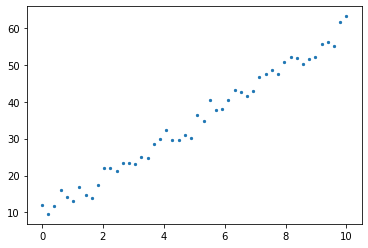

In [25]:
plt.scatter(x,y,s=5)

In [27]:
import pandas as pd

data = pd.DataFrame({"x":x,"y":y})
data.to_csv('simulated_data.csv',index=False)

In [6]:
param1 = np.linspace(0,20,100)
param1_likval = [myloglike([5,param]) for param in param1]

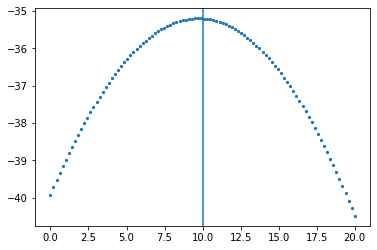

In [7]:
plt.scatter(param1,param1_likval,s=5)
plt.axvline(10)

In [8]:
param2 = np.linspace(0,10,100)
param2_likval = [myloglike([param,10]) for param in param2]

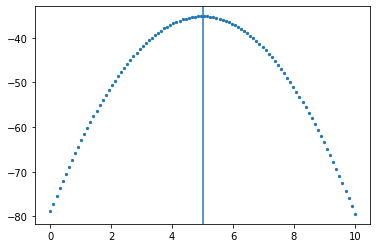

In [9]:
plt.scatter(param2,param2_likval,s=5)
plt.axvline(5)

In [10]:
np.random.normal(loc=0,scale=10)

0.6816069482110201

In [11]:
sampler = Sampler(log_likelihood=myloglike, prior=myprior, ndim = 2, sample_method = 'mcmc')
sampler.sample()

cube [0.8323846976627834, 0.1530297184106909] [8.323846976627834, 3.060594368213818]
Initial Upper Bound -36.046472276323335 -0.2 -36.24647227632334
New upper bound -36.046472276323335 -0.4 -36.446472276323334 0.0
New upper bound -36.046472276323335 -0.6 -36.64647227632334 0.0
New upper bound -36.046472276323335 -0.8 -36.84647227632333 0.0
New upper bound -36.046472276323335 -1.0 -37.046472276323335 0.0
New upper bound -36.046472276323335 -1.2 -37.24647227632334 0.0
New upper bound -36.046472276323335 -1.4 -37.446472276323334 0.0
New upper bound -36.046472276323335 -1.6 -37.64647227632334 0.0
New upper bound -36.046472276323335 -1.8 -37.84647227632333 0.0
New upper bound -36.046472276323335 -2.0 -38.046472276323335 0.0
New upper bound -36.046472276323335 -2.2 -38.24647227632334 0.0
New upper bound -36.046472276323335 -2.4 -38.446472276323334 0.0
New upper bound -36.046472276323335 -2.6 -38.64647227632334 0.0
New upper bound -36.046472276323335 -2.8 -38.84647227632333 0.0
New upper boun

KeyboardInterrupt: 

In [29]:
pymultinest.run(myloglike, myprior, 2, outputfiles_basename='./1-',resume = False, verbose = True)